<a href="https://colab.research.google.com/github/NaviaEddy/SIS421_LAB02/blob/main/Lab2_NaviaCondoriEddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importamos las librerias
import torch
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0
                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset



In [4]:
def cargar_dataset_test(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # Normalizar la imagen
                    imagen = np.array(imagen) / 255.0
                    # Convertir la imagen normalizada a objeto PIL
                    imagen_pil = Image.fromarray((imagen * 255).astype(np.uint8))
                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset



In [5]:
trainset = cargar_dataset_train('/content/drive/MyDrive/SIS421/LAB_2/Training Data')
testset = cargar_dataset_test('/content/drive/MyDrive/SIS421/LAB_2/Testing Data')

print("Número de ejemplos en el conjunto de entrenamiento:", len(trainset))
print("Número de ejemplos en el conjunto de prueba:", len(testset))

Número de ejemplos en el conjunto de entrenamiento: 30000
Número de ejemplos en el conjunto de prueba: 2407


In [6]:
classes = ('Beatle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo',
           'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra')

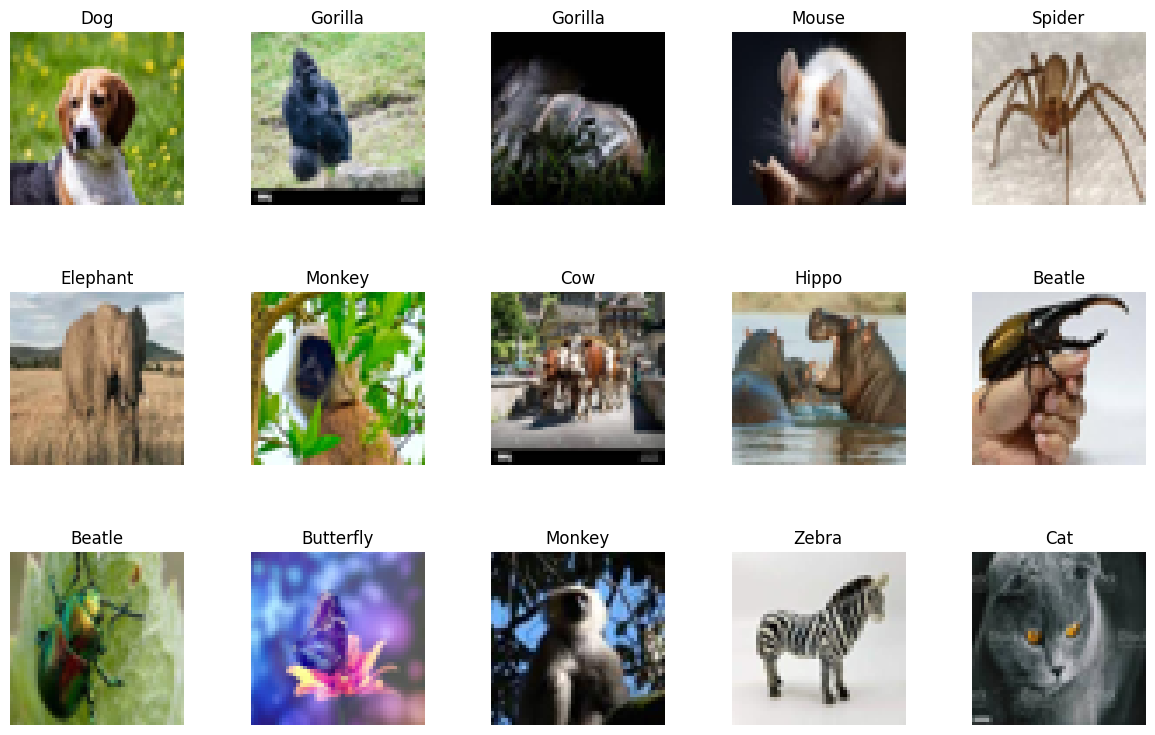

In [7]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c*3, r*3))
for row in range(r):
    for col in range(c):
        index = c*row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset)-1)
        img, label = trainset[ix]
        #print(label)
        #clase_index = classes.index(clase)
        plt.imshow(img)
        plt.axis('off')
        plt.title(classes[label])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
# convertimos imágenes a arrays de numpy
train_images = np.array([np.array(img) for img, label in trainset])
test_images = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
test_labels = np.array([label for img, label in testset])

In [ ]:
# ver número de imágenes, resolución y número de canales
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((30000, 50, 50, 3), (2407, 50, 50, 3), (30000,), (2407,))

# **RECETA DE ENTRENAMIENTO**

#Verificacion de datos

In [ ]:
# tipo de datos
train_images.dtype, train_labels.dtype

(dtype('uint8'), dtype('int64'))

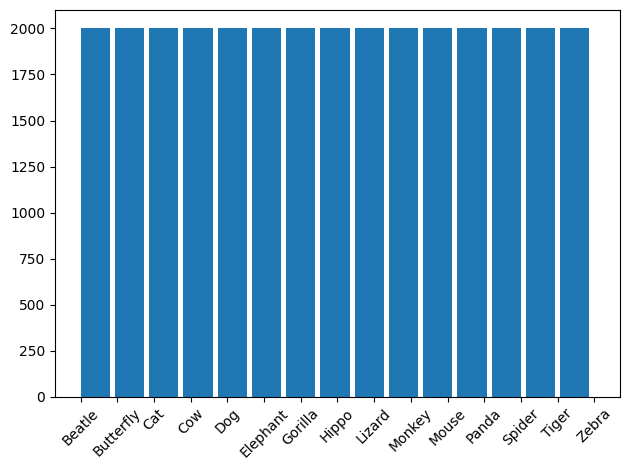

In [ ]:
# Visualización del histograma
plt.hist(train_labels, bins=len(classes), width=0.8)
plt.xticks(range(len(classes)), classes, rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
(unique, counts)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 array([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000,
        2000, 2000, 2000, 2000]))

#Validando MLP

In [8]:
def build_model(D_in=50*50*3, H=100, D_out=15):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

In [ ]:
#Enviamos un batch de 64 y la salida deberia ser un vector de 15 valores por cada imagen del batch
model = build_model()
test_input = torch.randn((64, 50*50*3))
test_output = model(test_input)
test_output.shape

torch.Size([64, 15])

In [6]:
train_images = np.array([np.array(img) for img, label in trainset])
X_test = np.array([np.array(img) for img, label in testset])

train_labels = np.array([label for img, label in trainset])
y_test = np.array([label for img, label in testset])

X_train, X_val, X_subset = train_images[:20000], train_images[20000:], train_images[:5000]
y_train, y_val, y_subset = train_labels[:20000], train_labels[20000:], train_labels[:5000]

X_train.shape, X_val.shape, X_test.shape, X_subset.shape

((20000, 50, 50, 3), (10000, 50, 50, 3), (2407, 50, 50, 3), (5000, 50, 50, 3))

Una vez nos hemos asegurado que las dimensiones de nuestra red están bien, el siguiente paso es asegurarnos de que es capaz de aprenderse de memoria una sola muestra del dataset.

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 50*50*3)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

In [ ]:
# fit de una imagen del dataset
dataset = Dataset(X_subset[3:4], y_subset[3:4])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

len(dataset)

1

Podemos ver que logramos el fit de una sola imagen sin problema

In [ ]:
epochs = 5
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for e in range(1, epochs+1):
    for x_b, y_b in dataloader:
        #print(y_b)
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {e}/{epochs} loss {loss.item():.5f} y {y_b.item()} y_pred {torch.argmax(y_pred, axis=1).item()}")

Epoch 1/5 loss 2.56063 y 2 y_pred 2
Epoch 2/5 loss 0.00000 y 2 y_pred 2
Epoch 3/5 loss 0.00000 y 2 y_pred 2
Epoch 4/5 loss 0.00000 y 2 y_pred 2
Epoch 5/5 loss 0.00000 y 2 y_pred 2


Ahora siguiendo la misma logica del anterior entrenamiento, el modelo deberia ser capaz de aprenderse de memoria un solo batch de imagenes

In [ ]:
# fit de un batch

dataset = Dataset(X_subset[:64], y_subset[:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

len(dataset)

64

In [ ]:
epochs = 200
criterion = torch.nn.CrossEntropyLoss()
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
for e in range(1, epochs+1):
    for x_b, y_b in dataloader:
        y_pred = model(x_b)
        loss = criterion(y_pred, y_b)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (y_b == torch.argmax(y_pred, axis=1)).sum().item()
        #print(acc)
        if not e % 10:
            print(f"Epoch {e}/{epochs} loss {loss.item():.5f} acc {acc}/{y_b.shape[0]}")

Epoch 10/200 loss 2.14696 acc 31/64
Epoch 20/200 loss 1.35925 acc 49/64
Epoch 30/200 loss 0.56740 acc 62/64
Epoch 40/200 loss 0.15508 acc 64/64
Epoch 50/200 loss 0.04272 acc 64/64
Epoch 60/200 loss 0.01659 acc 64/64
Epoch 70/200 loss 0.00913 acc 64/64
Epoch 80/200 loss 0.00630 acc 64/64
Epoch 90/200 loss 0.00491 acc 64/64
Epoch 100/200 loss 0.00406 acc 64/64
Epoch 110/200 loss 0.00348 acc 64/64
Epoch 120/200 loss 0.00304 acc 64/64
Epoch 130/200 loss 0.00269 acc 64/64
Epoch 140/200 loss 0.00240 acc 64/64
Epoch 150/200 loss 0.00215 acc 64/64
Epoch 160/200 loss 0.00194 acc 64/64
Epoch 170/200 loss 0.00176 acc 64/64
Epoch 180/200 loss 0.00161 acc 64/64
Epoch 190/200 loss 0.00147 acc 64/64
Epoch 200/200 loss 0.00135 acc 64/64


#Entrenando sub-conjunto de datos

In [ ]:
dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [10]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def fit(model, dataloader, optimizer, scheduler=None, epochs=None, log_each=1, weight_decay=0, early_stopping=0, verbose=1):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.numpy(), y_probas.detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.numpy(), y_probas.numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            if verbose == 2:
                print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each and verbose:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [ ]:
# Ver que learning rate es adecuado
lrs = [0.0001, 0.0003, 0.0005]
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)


Probando lr 0.0001
Probando lr 0.0003
Probando lr 0.0005


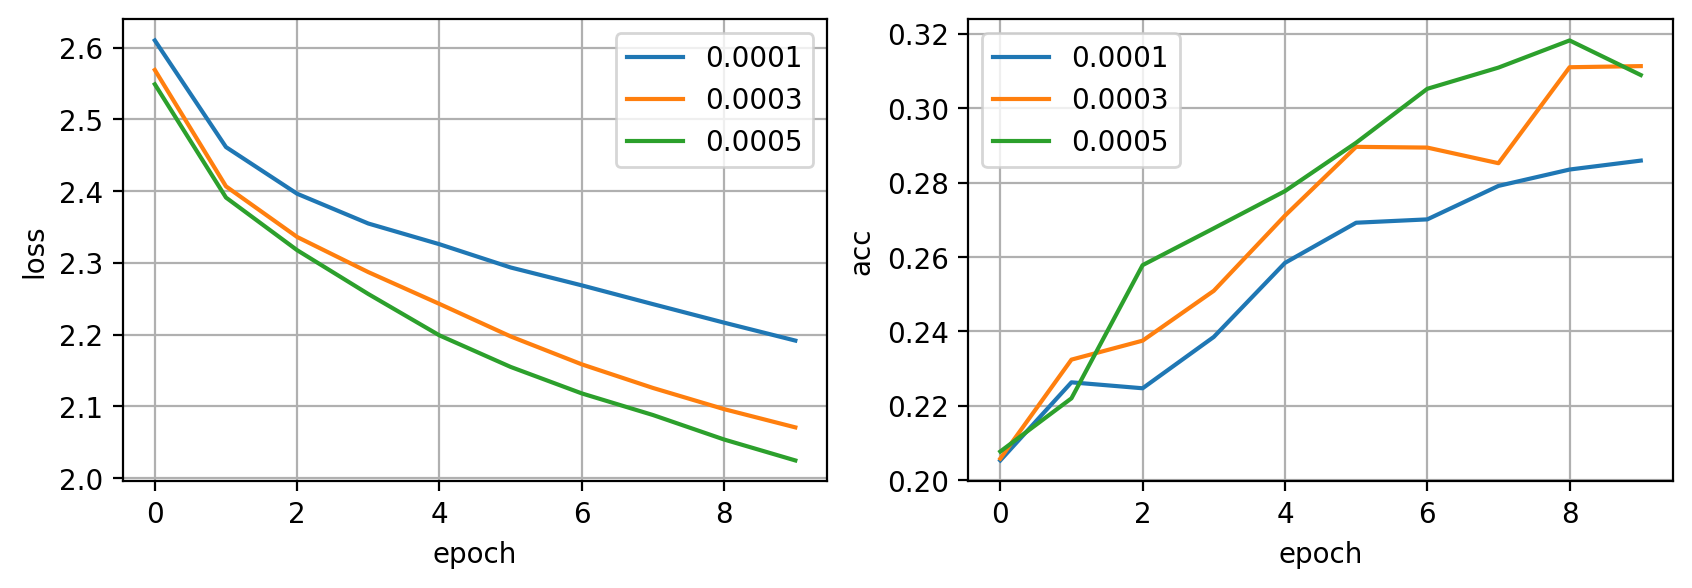

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

Repetimos lo mismo pero ahora con todos los datos

In [13]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=32, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(20000, 10000)

In [ ]:
hists = []
for lr in lrs:
    print(f"Probando lr {lr}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=10, verbose=0)
    hists.append(hist)

Probando lr 0.0001
Probando lr 0.0003
Probando lr 0.0005


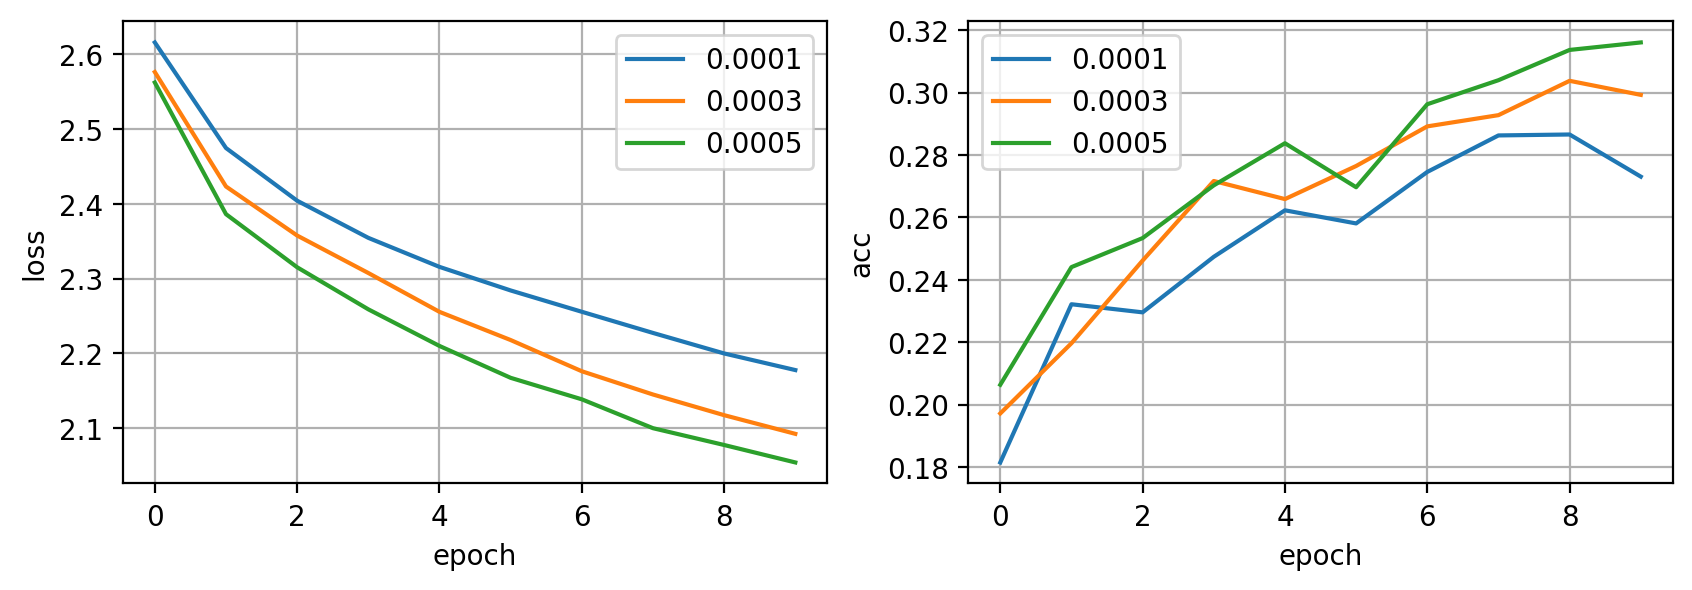

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(lrs)):
    ax.plot(hists[i]['loss'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(lrs)):
    ax.plot(hists[i]['val_acc'], label=lrs[i])
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

#Tuneado de hyperparámetros

In [14]:
bss = [16, 32, 64, 128, 256]
lrs = [0.0001, 0.0003, 0.0005]
n = 5
hists = []
for i in range(n):
    lr = random.choice(lrs)
    bs = random.choice(bss)
    print(f"Test {i+1} lr {lr} bs {bs}")
    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    hist = fit(model, dataloader, optimizer, epochs=20, verbose=0)
    hists.append({'hist': hist, 'lr': lr, 'bs': bs})

Test 1 lr 0.0001 bs 256
Test 2 lr 0.0001 bs 32
Test 3 lr 0.0005 bs 32
Test 4 lr 0.0003 bs 256
Test 5 lr 0.0005 bs 128


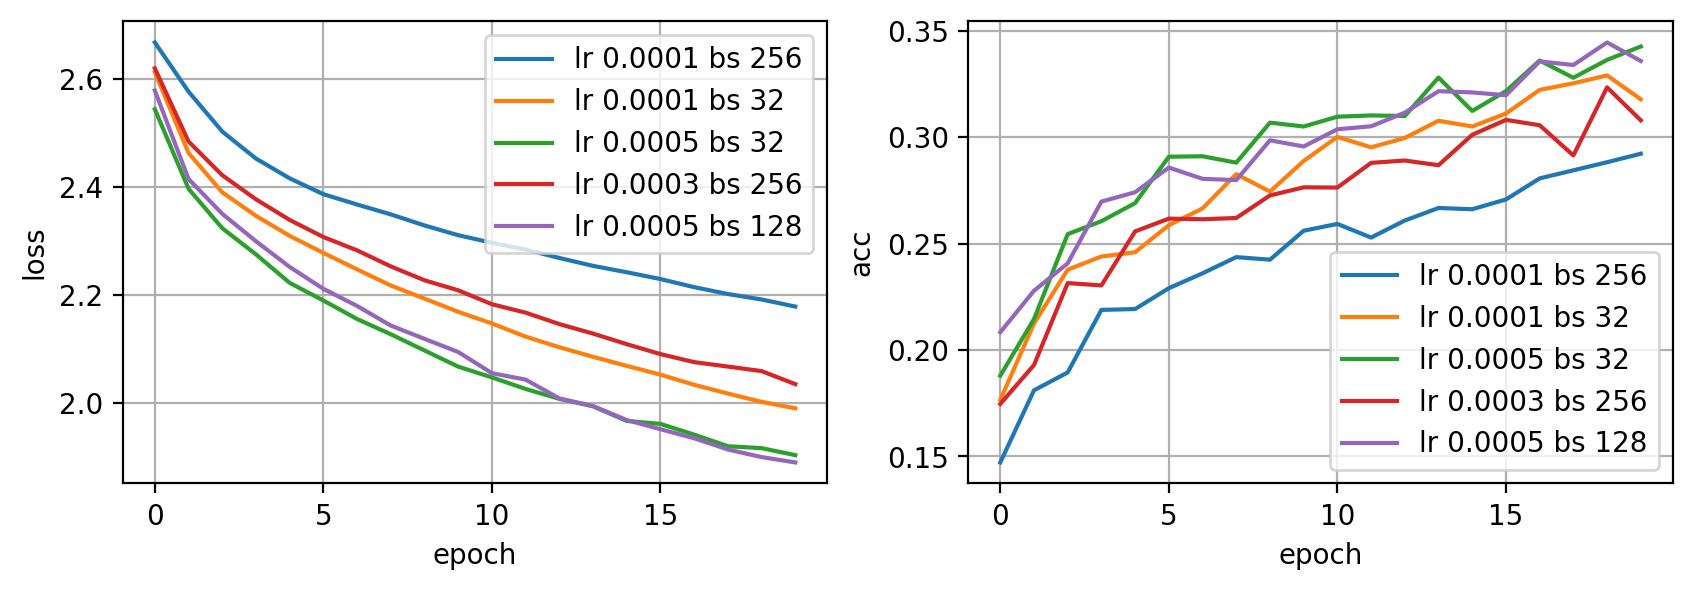

In [15]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['loss'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
for i in range(len(hists)):
    ax.plot(hists[i]['hist']['val_acc'], label=f'lr {hists[i]["lr"]} bs {hists[i]["bs"]}')
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

# **APLICANDO LOS CONCEPTOS DE REGULARIZACION**

# MLP sin ninguna regularizacion

In [35]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 50*50*3)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=128, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [14]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=50*50*3, H=100, D_out=15):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

def fit(model, dataloader, epochs=200, log_each=10, weight_decay=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [ ]:
model = build_model()
hist = fit(model, dataloader)

Epoch 10/200 loss 2.36944 acc 0.22512 val_loss 2.74961 val_acc 0.14660
Epoch 20/200 loss 2.24265 acc 0.26533 val_loss 2.56833 val_acc 0.18740
Epoch 30/200 loss 2.05887 acc 0.32544 val_loss 2.59579 val_acc 0.19750
Epoch 40/200 loss 1.92482 acc 0.37540 val_loss 2.81099 val_acc 0.20870
Epoch 50/200 loss 1.80906 acc 0.41819 val_loss 4.34594 val_acc 0.15060
Epoch 60/200 loss 1.64253 acc 0.46357 val_loss 2.92252 val_acc 0.22470
Epoch 70/200 loss 1.54422 acc 0.49164 val_loss 3.43555 val_acc 0.22550
Epoch 80/200 loss 1.44487 acc 0.53284 val_loss 3.58035 val_acc 0.21410
Epoch 90/200 loss 1.30134 acc 0.57345 val_loss 5.32373 val_acc 0.19490
Epoch 100/200 loss 1.33117 acc 0.56688 val_loss 3.85572 val_acc 0.22550
Epoch 110/200 loss 1.28819 acc 0.58459 val_loss 7.57307 val_acc 0.15990
Epoch 120/200 loss 1.07882 acc 0.65685 val_loss 7.95422 val_acc 0.17300
Epoch 130/200 loss 1.05299 acc 0.65864 val_loss 4.81728 val_acc 0.21400
Epoch 140/200 loss 1.63131 acc 0.52647 val_loss 4.37254 val_acc 0.20820
E

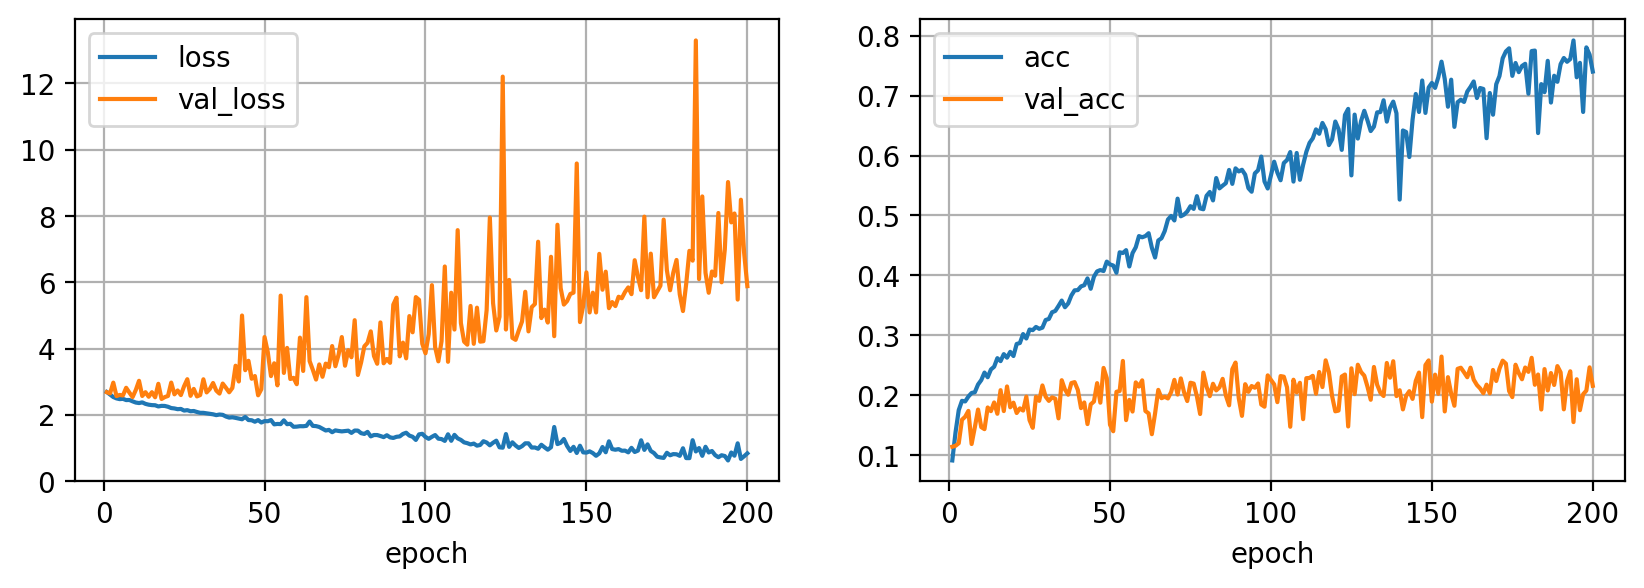

In [ ]:
import pandas as pd

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

# MLP aplicando L2 y Early_stopping

In [28]:
def fit(model, dataloader, epochs=200, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=weight_decay)
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [20]:
model = build_model()
hist = fit(model, dataloader, weight_decay=0.01, early_stopping=20)

Mejor modelo guardado con acc 0.07120 en epoch 1
Mejor modelo guardado con acc 0.07480 en epoch 2
Epoch 10/200 loss 2.70043 acc 0.07539 val_loss 2.70188 val_acc 0.06960
Epoch 20/200 loss 2.69506 acc 0.07988 val_loss 2.69826 val_acc 0.07130
Entrenamiento detenido en epoch 22 por no mejorar en 20 epochs seguidas


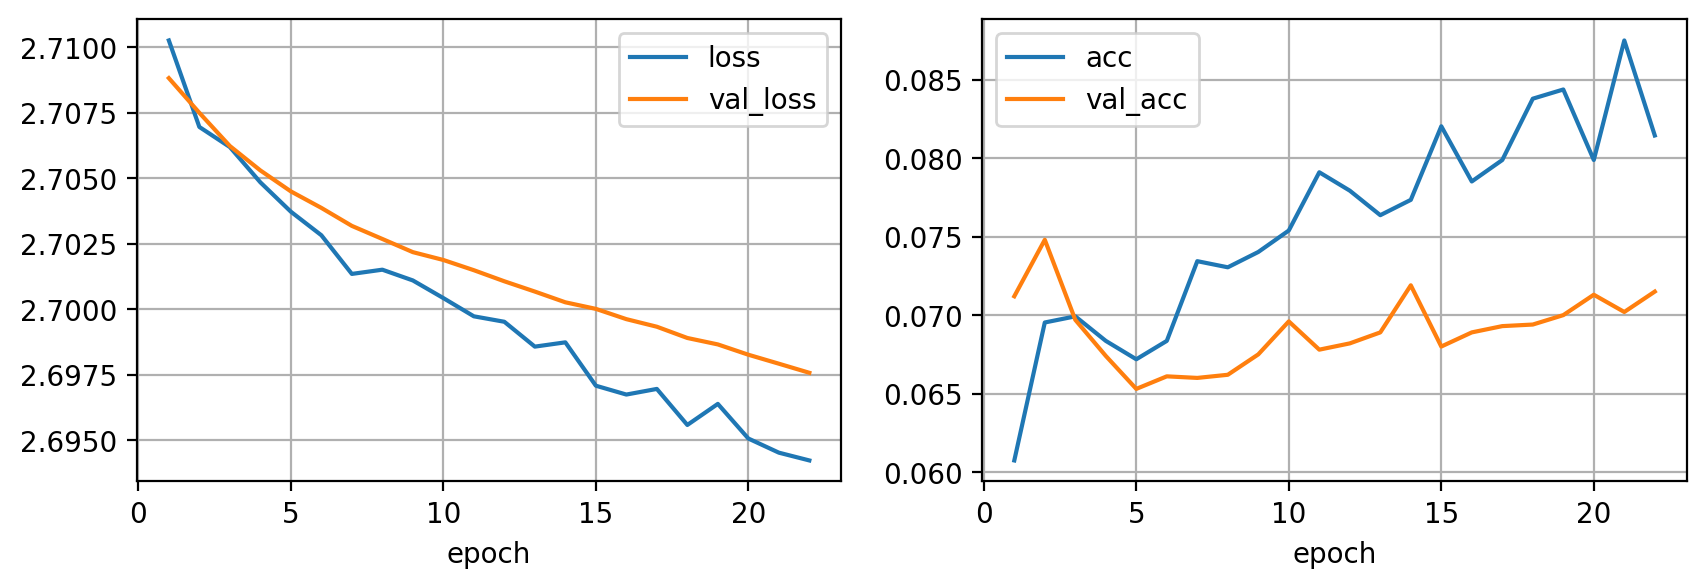

In [21]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

# Añadiendole Dropout

In [10]:
def build_model(D_in=50*50*3, H=100, D_out=15, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    )

In [36]:
model = build_model(p=0.5)
hist = fit(model, dataloader)

Mejor modelo guardado con acc 0.07780 en epoch 1
Mejor modelo guardado con acc 0.10380 en epoch 6
Mejor modelo guardado con acc 0.11430 en epoch 8
Epoch 10/200 loss 2.66398 acc 0.10938 val_loss 2.67537 val_acc 0.11160
Mejor modelo guardado con acc 0.13540 en epoch 11
Mejor modelo guardado con acc 0.14400 en epoch 16
Epoch 20/200 loss 2.62132 acc 0.12402 val_loss 2.61390 val_acc 0.13300
Mejor modelo guardado con acc 0.16800 en epoch 21
Mejor modelo guardado con acc 0.16830 en epoch 30
Epoch 30/200 loss 2.55733 acc 0.15957 val_loss 2.54618 val_acc 0.16830
Epoch 40/200 loss 2.60704 acc 0.13828 val_loss 2.62403 val_acc 0.12860
Mejor modelo guardado con acc 0.20510 en epoch 50
Epoch 50/200 loss 2.56353 acc 0.15371 val_loss 2.50312 val_acc 0.20510
Epoch 60/200 loss 2.51979 acc 0.17168 val_loss 2.54139 val_acc 0.15020
Mejor modelo guardado con acc 0.20900 en epoch 63
Epoch 70/200 loss 2.58611 acc 0.15684 val_loss 2.58179 val_acc 0.14420
Epoch 80/200 loss 2.49555 acc 0.18066 val_loss 2.64425 v

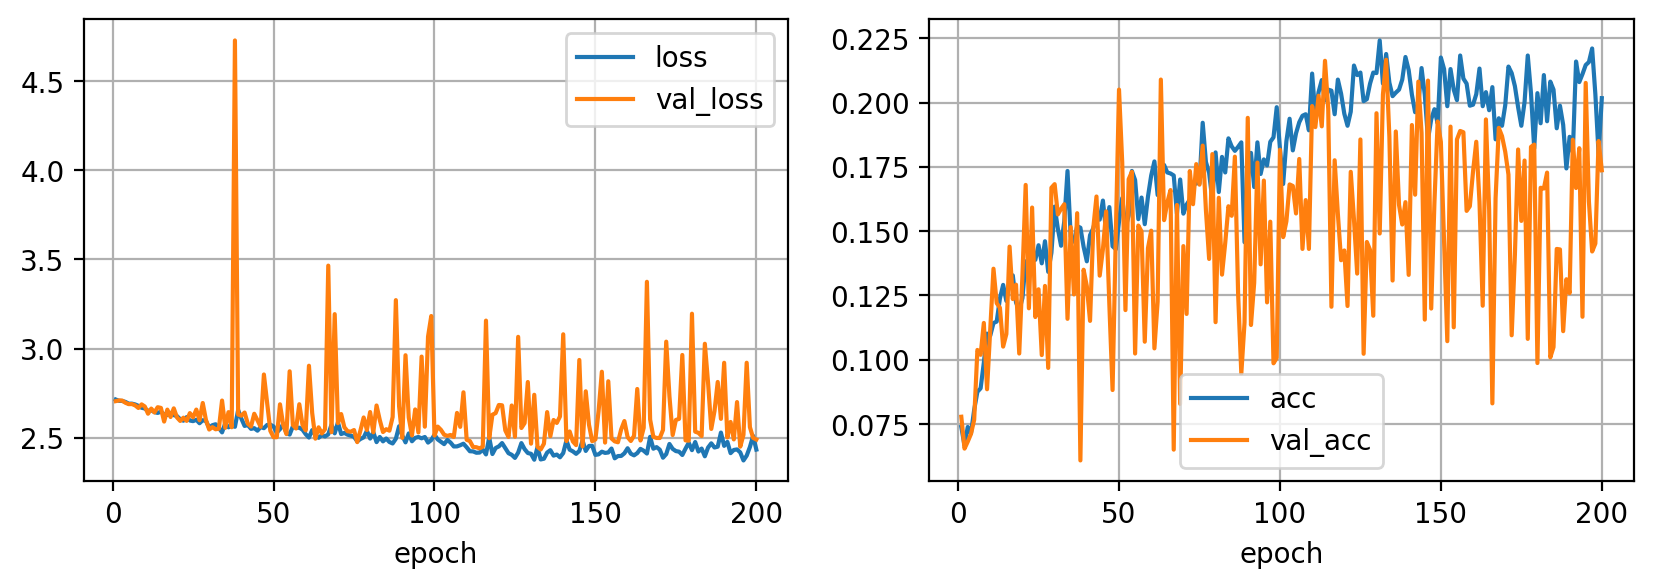

In [37]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

# Usando todos los datos

In [29]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(20000, 10000)

In [30]:
model = build_model()
hist = fit(model, dataloader, early_stopping=10)

Mejor modelo guardado con acc 0.11990 en epoch 1
Mejor modelo guardado con acc 0.17530 en epoch 2
Mejor modelo guardado con acc 0.19170 en epoch 3
Mejor modelo guardado con acc 0.19910 en epoch 4
Mejor modelo guardado con acc 0.21210 en epoch 5
Mejor modelo guardado con acc 0.24300 en epoch 6
Epoch 10/200 loss 2.30024 acc 0.26802 val_loss 2.37225 val_acc 0.23210
Mejor modelo guardado con acc 0.25140 en epoch 11
Mejor modelo guardado con acc 0.27290 en epoch 14
Mejor modelo guardado con acc 0.27900 en epoch 16
Mejor modelo guardado con acc 0.29080 en epoch 20
Epoch 20/200 loss 2.12270 acc 0.32693 val_loss 2.23302 val_acc 0.29080
Mejor modelo guardado con acc 0.30590 en epoch 22
Mejor modelo guardado con acc 0.31380 en epoch 23
Mejor modelo guardado con acc 0.32080 en epoch 30
Epoch 30/200 loss 1.97457 acc 0.37814 val_loss 2.12577 val_acc 0.32080
Mejor modelo guardado con acc 0.32300 en epoch 32
Mejor modelo guardado con acc 0.35000 en epoch 35
Epoch 40/200 loss 1.84708 acc 0.41723 val_l

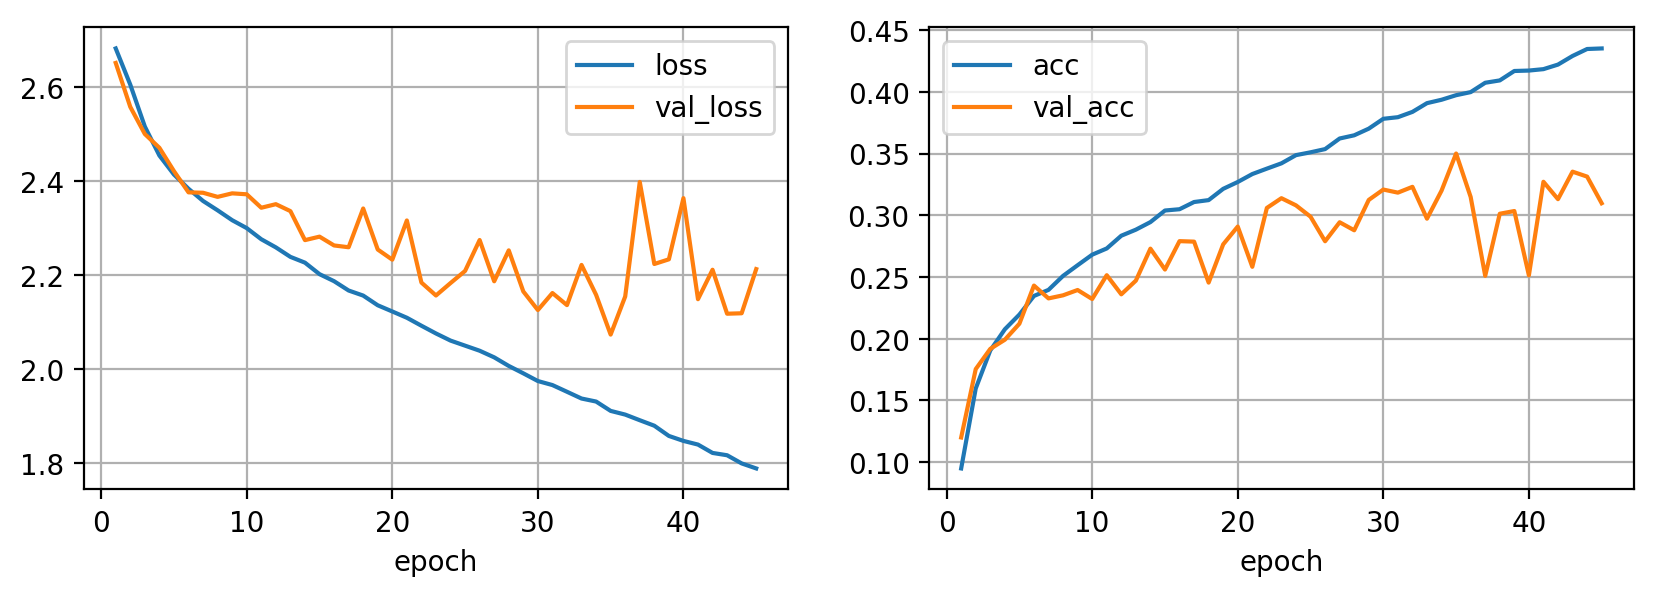

In [31]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

# Usando Data_Augmentation


In [32]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(50, 50),
    HorizontalFlip(),
    OneOf([
        ToGray(p=0.2),
        RGBShift(p=0.3)
    ])
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().view(-1)
        label = torch.tensor(self.Y[ix]).long()
        return img, label

dataset = {
    'train': Dataset(X_train, y_train, trans=trans),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=128, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(20000, 10000)

In [33]:
model = build_model()
hist = fit(model, dataloader, early_stopping=20)

Mejor modelo guardado con acc 0.10980 en epoch 1
Mejor modelo guardado con acc 0.11930 en epoch 2
Mejor modelo guardado con acc 0.14870 en epoch 4
Mejor modelo guardado con acc 0.16440 en epoch 6
Mejor modelo guardado con acc 0.17470 en epoch 9
Mejor modelo guardado con acc 0.18590 en epoch 10
Epoch 10/200 loss 2.55344 acc 0.16240 val_loss 2.49894 val_acc 0.18590
Mejor modelo guardado con acc 0.18790 en epoch 12
Mejor modelo guardado con acc 0.19390 en epoch 15
Mejor modelo guardado con acc 0.20270 en epoch 19
Epoch 20/200 loss 2.50486 acc 0.17730 val_loss 2.46520 val_acc 0.19160
Mejor modelo guardado con acc 0.20980 en epoch 27
Epoch 30/200 loss 2.46385 acc 0.19370 val_loss 2.43914 val_acc 0.20400
Mejor modelo guardado con acc 0.20990 en epoch 31
Mejor modelo guardado con acc 0.21360 en epoch 33
Mejor modelo guardado con acc 0.22040 en epoch 36
Epoch 40/200 loss 2.43756 acc 0.20640 val_loss 2.42173 val_acc 0.21950
Mejor modelo guardado con acc 0.22040 en epoch 44
Mejor modelo guardado

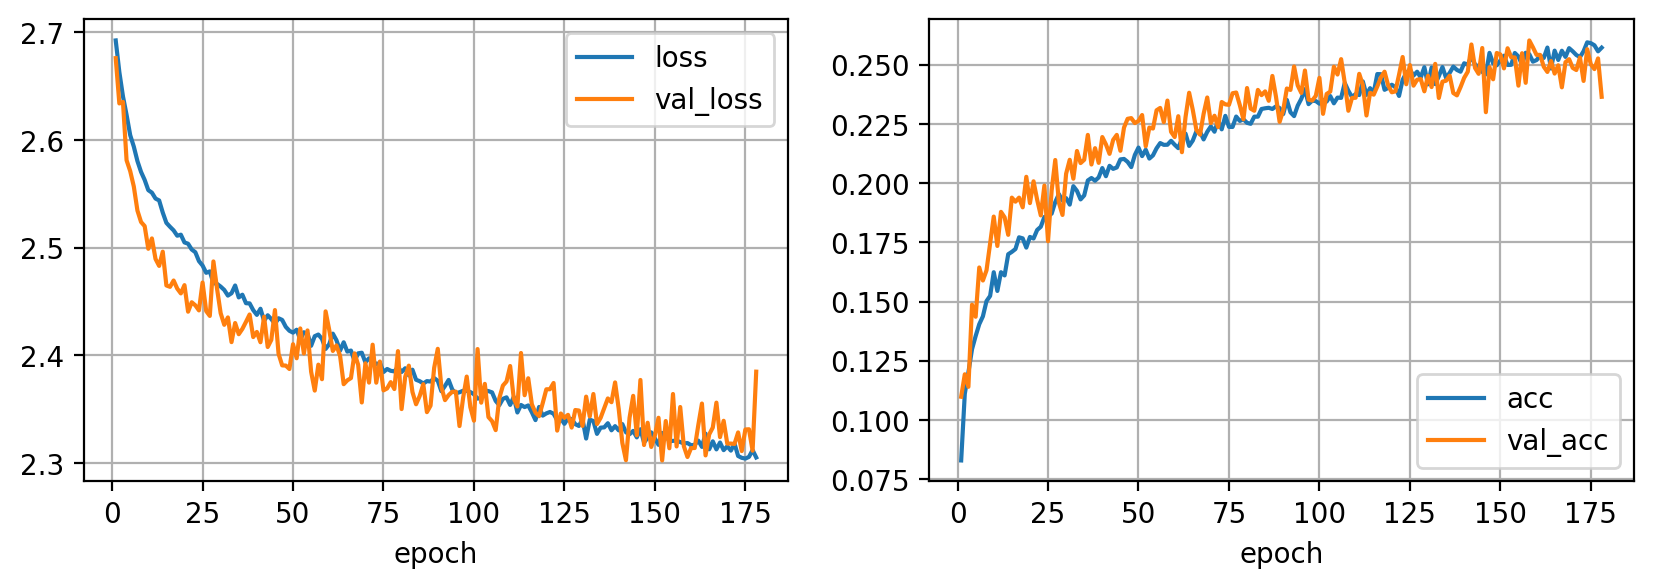

In [34]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

# **APLICANDO CONCEPTOS DE OPTIMIZACION**

In [40]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().view(-1, 50*50*3)
        self.Y = torch.from_numpy(Y).long()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_subset, y_subset),
    'val': Dataset(X_val, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=128, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(5000, 10000)

In [41]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=50*50*3, H=100, D_out=15):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

def fit(model, dataloader, optimizer, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc = [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

# Sin optimizador

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
hist_sgd = fit(model, dataloader, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.09660 en epoch 1
Mejor modelo guardado con acc 0.10920 en epoch 6
Mejor modelo guardado con acc 0.11950 en epoch 8
Mejor modelo guardado con acc 0.12960 en epoch 9
Epoch 10/100 loss 2.66540 acc 0.14331 val_loss 2.66544 val_acc 0.12960
Mejor modelo guardado con acc 0.13610 en epoch 11
Mejor modelo guardado con acc 0.14670 en epoch 13
Mejor modelo guardado con acc 0.15080 en epoch 15
Mejor modelo guardado con acc 0.15440 en epoch 16
Mejor modelo guardado con acc 0.15790 en epoch 18
Mejor modelo guardado con acc 0.16430 en epoch 19
Mejor modelo guardado con acc 0.16520 en epoch 20
Epoch 20/100 loss 2.60760 acc 0.18073 val_loss 2.61299 val_acc 0.16520
Mejor modelo guardado con acc 0.17010 en epoch 21
Mejor modelo guardado con acc 0.18090 en epoch 22
Mejor modelo guardado con acc 0.18120 en epoch 25
Mejor modelo guardado con acc 0.18310 en epoch 27
Mejor modelo guardado con acc 0.18740 en epoch 28
Epoch 30/100 loss 2.54574 acc 0.19885 val_loss 2.56377 val_acc

# Momentum

In [42]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
hist_momentum = fit(model, dataloader, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.12100 en epoch 1
Mejor modelo guardado con acc 0.12790 en epoch 3
Mejor modelo guardado con acc 0.13130 en epoch 5
Epoch 10/100 loss 2.54605 acc 0.14062 val_loss 2.65963 val_acc 0.10840
Mejor modelo guardado con acc 0.13980 en epoch 11
Mejor modelo guardado con acc 0.14090 en epoch 20
Epoch 20/100 loss 2.49330 acc 0.16191 val_loss 2.55021 val_acc 0.14090
Entrenamiento detenido en epoch 30 por no mejorar en 10 epochs seguidas


# RMSProp

In [ ]:
model = build_model()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
hist_rms = fit(model, dataloader, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.09010 en epoch 1
Mejor modelo guardado con acc 0.11100 en epoch 2
Mejor modelo guardado con acc 0.13190 en epoch 3
Mejor modelo guardado con acc 0.16670 en epoch 4
Mejor modelo guardado con acc 0.17150 en epoch 5
Mejor modelo guardado con acc 0.18290 en epoch 6
Mejor modelo guardado con acc 0.20340 en epoch 9
Mejor modelo guardado con acc 0.22250 en epoch 10
Epoch 10/100 loss 2.29576 acc 0.26135 val_loss 2.40227 val_acc 0.22250
Mejor modelo guardado con acc 0.23520 en epoch 16
Epoch 20/100 loss 2.11128 acc 0.31409 val_loss 2.60623 val_acc 0.19260
Mejor modelo guardado con acc 0.25380 en epoch 22
Mejor modelo guardado con acc 0.25690 en epoch 28
Epoch 30/100 loss 1.97667 acc 0.35928 val_loss 2.46193 val_acc 0.24290
Mejor modelo guardado con acc 0.26050 en epoch 36
Epoch 40/100 loss 1.84840 acc 0.39889 val_loss 2.49463 val_acc 0.24860
Entrenamiento detenido en epoch 46 por no mejorar en 10 epochs seguidas


# Adam

In [ ]:
model = build_model()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist_adam = fit(model, dataloader, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.15180 en epoch 1
Mejor modelo guardado con acc 0.18170 en epoch 2
Mejor modelo guardado con acc 0.20710 en epoch 4
Mejor modelo guardado con acc 0.20790 en epoch 5
Mejor modelo guardado con acc 0.22650 en epoch 6
Mejor modelo guardado con acc 0.23660 en epoch 10
Epoch 10/100 loss 2.22174 acc 0.28045 val_loss 2.36293 val_acc 0.23660
Mejor modelo guardado con acc 0.24380 en epoch 12
Mejor modelo guardado con acc 0.25130 en epoch 14
Mejor modelo guardado con acc 0.25800 en epoch 15
Mejor modelo guardado con acc 0.26160 en epoch 18
Epoch 20/100 loss 2.01247 acc 0.34952 val_loss 2.43808 val_acc 0.24520
Mejor modelo guardado con acc 0.26640 en epoch 26
Mejor modelo guardado con acc 0.26860 en epoch 28
Epoch 30/100 loss 1.80690 acc 0.41063 val_loss 2.45265 val_acc 0.26420
Mejor modelo guardado con acc 0.26930 en epoch 32
Mejor modelo guardado con acc 0.27270 en epoch 33
Epoch 40/100 loss 1.65329 acc 0.46338 val_loss 2.52473 val_acc 0.26670
Entrenamiento detenid

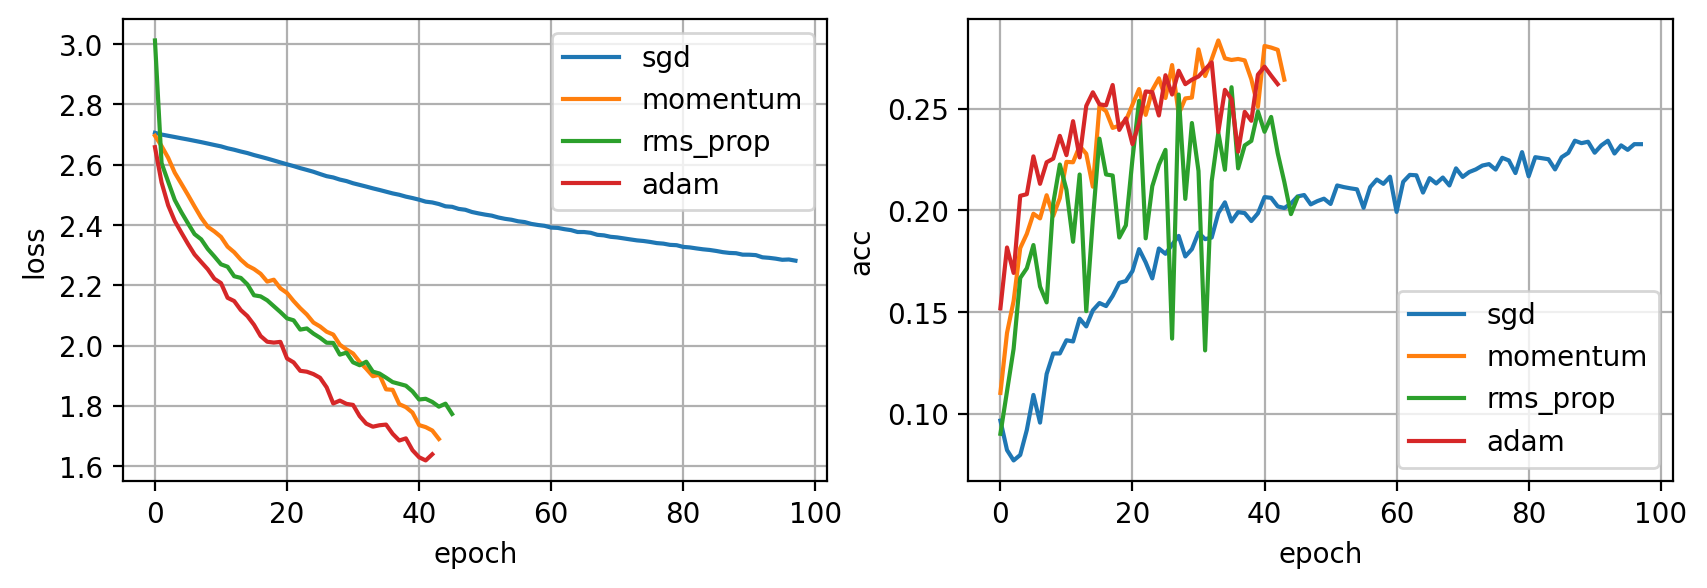

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_sgd['loss'], label="sgd")
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_rms['loss'], label="rms_prop")
ax.plot(hist_adam['loss'], label="adam")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_sgd['val_acc'], label="sgd")
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_rms['val_acc'], label="rms_prop")
ax.plot(hist_adam['val_acc'], label="adam")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

# Learning_rate_scheduling

In [ ]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=100, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

# StepLR

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# multiplica el lr por 0.1 cada 10 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)

hist_step = fit(model, dataloader, optimizer, scheduler, epochs=30, early_stopping=10)

Mejor modelo guardado con acc 0.09110 en epoch 1
Mejor modelo guardado con acc 0.12870 en epoch 2
Mejor modelo guardado con acc 0.15470 en epoch 3
Mejor modelo guardado con acc 0.18130 en epoch 4
Mejor modelo guardado con acc 0.18590 en epoch 5
Mejor modelo guardado con acc 0.19570 en epoch 6
Mejor modelo guardado con acc 0.20240 en epoch 7
Mejor modelo guardado con acc 0.21650 en epoch 8
Epoch 10/30 loss 2.35756 acc 0.23945 val_loss 2.41994 val_acc 0.21070 lr 0.00100
Mejor modelo guardado con acc 0.22590 en epoch 11
Mejor modelo guardado con acc 0.22730 en epoch 12
Mejor modelo guardado con acc 0.23000 en epoch 13
Mejor modelo guardado con acc 0.23250 en epoch 15
Epoch 20/30 loss 2.28702 acc 0.27468 val_loss 2.38543 val_acc 0.23130 lr 0.00010
Entrenamiento detenido en epoch 25 por no mejorar en 10 epochs seguidas


# CyclicLR

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# aumenta el lr por 5 epochs, luego decrece
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size_up=5, step_size_down=25)

hist_cycle = fit(model, dataloader, optimizer, scheduler, epochs=30, early_stopping=10)

Mejor modelo guardado con acc 0.08550 en epoch 1
Mejor modelo guardado con acc 0.12360 en epoch 2
Mejor modelo guardado con acc 0.13430 en epoch 3
Mejor modelo guardado con acc 0.18150 en epoch 4
Mejor modelo guardado con acc 0.21220 en epoch 5
Mejor modelo guardado con acc 0.21650 en epoch 9
Mejor modelo guardado con acc 0.24170 en epoch 10
Epoch 10/30 loss 2.27232 acc 0.26771 val_loss 2.36499 val_acc 0.24170 lr 0.00842
Mejor modelo guardado con acc 0.24990 en epoch 13
Mejor modelo guardado con acc 0.25600 en epoch 14
Mejor modelo guardado con acc 0.26350 en epoch 17
Mejor modelo guardado con acc 0.26490 en epoch 19
Mejor modelo guardado con acc 0.27130 en epoch 20
Epoch 20/30 loss 1.92894 acc 0.38396 val_loss 2.36339 val_acc 0.27130 lr 0.00446
Mejor modelo guardado con acc 0.27300 en epoch 21
Mejor modelo guardado con acc 0.28020 en epoch 23
Mejor modelo guardado con acc 0.29160 en epoch 25
Mejor modelo guardado con acc 0.29510 en epoch 30
Epoch 30/30 loss 1.45059 acc 0.55195 val_los

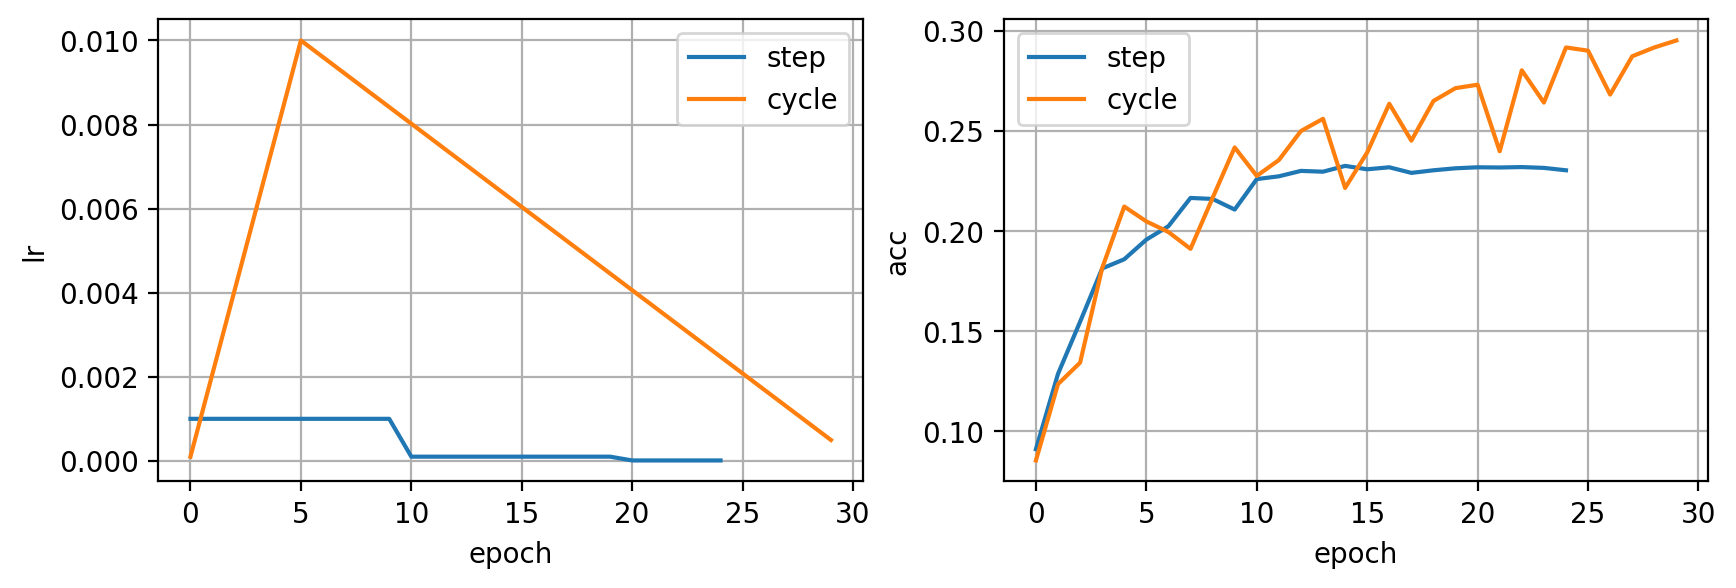

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_step['lr'], label="step")
ax.plot(hist_cycle['lr'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('lr')
ax = plt.subplot(122)
ax.plot(hist_step['val_acc'], label="step")
ax.plot(hist_cycle['val_acc'], label="cycle")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

# Normalizacion

In [37]:
import numpy as np

mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.52439813, 0.50905477, 0.43398166]),
 array([0.27549254, 0.26727727, 0.28476294]))

In [43]:
train_images_norm = ((train_images / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(array([-3.44573364e-13, -1.09951066e-11, -5.65547064e-11]),
 array([1., 1., 1.]))

In [44]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in testset])

X_train_norm, X_val_norm, X_subset_norm = train_images_norm[:20000], train_images_norm[20000:], train_images_norm[:5000]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

((20000, 50, 50, 3), (10000, 50, 50, 3), (2407, 50, 50, 3), (5000, 50, 50, 3))

In [46]:
dataset_norm = {
    'train': Dataset(X_subset_norm, y_subset),
    'val': Dataset(X_val_norm, y_val),
}

dataloader_norm = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=128, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset_norm['train']), len(dataset_norm['val'])

(5000, 10000)

In [ ]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
hist_norm = fit(model, dataloader_norm, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.07990 en epoch 1
Mejor modelo guardado con acc 0.13440 en epoch 2
Mejor modelo guardado con acc 0.15620 en epoch 3
Mejor modelo guardado con acc 0.17230 en epoch 4
Mejor modelo guardado con acc 0.17340 en epoch 5
Mejor modelo guardado con acc 0.19370 en epoch 6
Mejor modelo guardado con acc 0.20060 en epoch 7
Mejor modelo guardado con acc 0.20910 en epoch 8
Mejor modelo guardado con acc 0.21000 en epoch 10
Epoch 10/100 loss 2.38040 acc 0.22751 val_loss 2.42818 val_acc 0.21000 lr 0.00100
Mejor modelo guardado con acc 0.22010 en epoch 11
Mejor modelo guardado con acc 0.22800 en epoch 12
Mejor modelo guardado con acc 0.23690 en epoch 14
Mejor modelo guardado con acc 0.23980 en epoch 16
Mejor modelo guardado con acc 0.24460 en epoch 17
Mejor modelo guardado con acc 0.24950 en epoch 18
Mejor modelo guardado con acc 0.25360 en epoch 19
Mejor modelo guardado con acc 0.25920 en epoch 20
Epoch 20/100 loss 2.19782 acc 0.30195 val_loss 2.33565 val_acc 0.25920 lr 0.

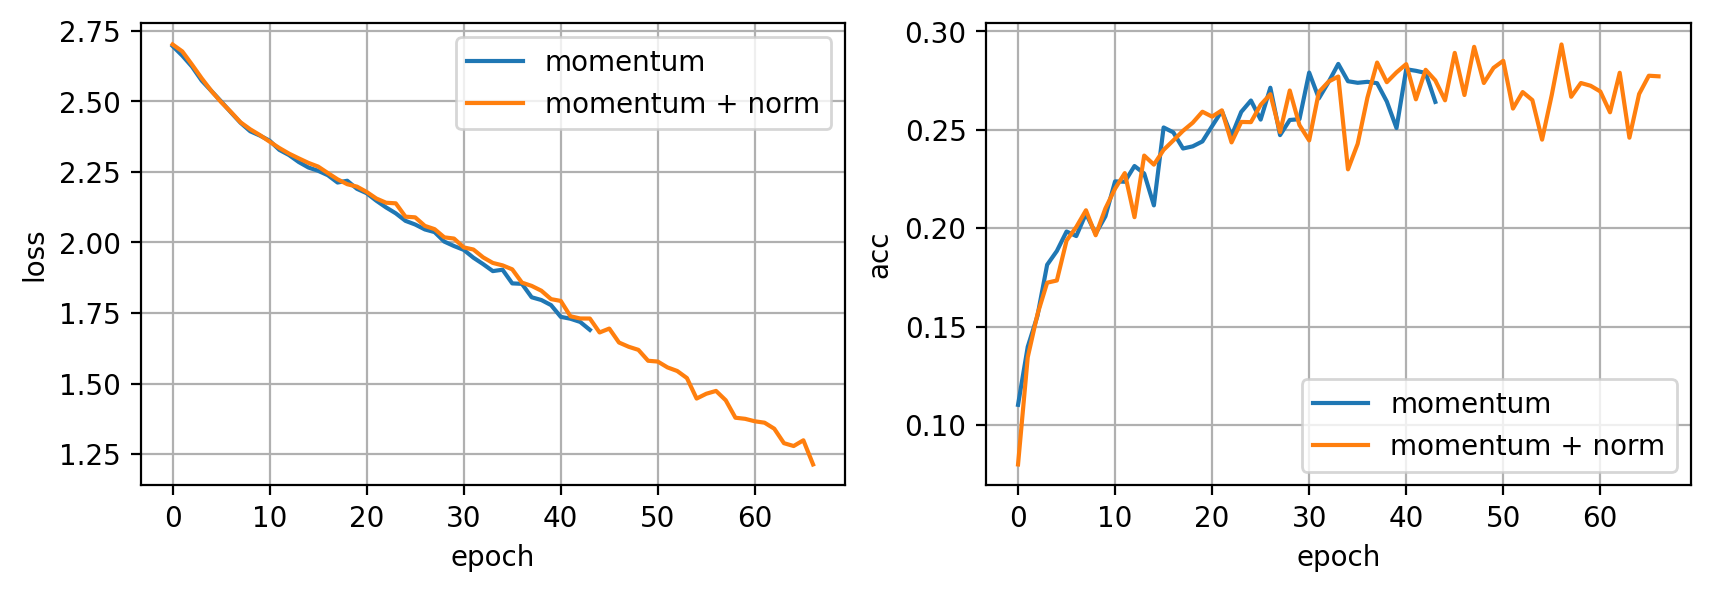

In [ ]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_norm['loss'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_norm['val_acc'], label="momentum + norm")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

# Batch_normalization

In [47]:
def build_model(D_in=50*50*3, H=100, D_out=15):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, H),
        torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out)
    )

In [48]:
model = build_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
hist_bn = fit(model, dataloader, optimizer, early_stopping=10)

Mejor modelo guardado con acc 0.18200 en epoch 1
Mejor modelo guardado con acc 0.21060 en epoch 2
Mejor modelo guardado con acc 0.21610 en epoch 4
Mejor modelo guardado con acc 0.22970 en epoch 5
Epoch 10/100 loss 1.46382 acc 0.53867 val_loss 3.80969 val_acc 0.18580
Entrenamiento detenido en epoch 15 por no mejorar en 10 epochs seguidas


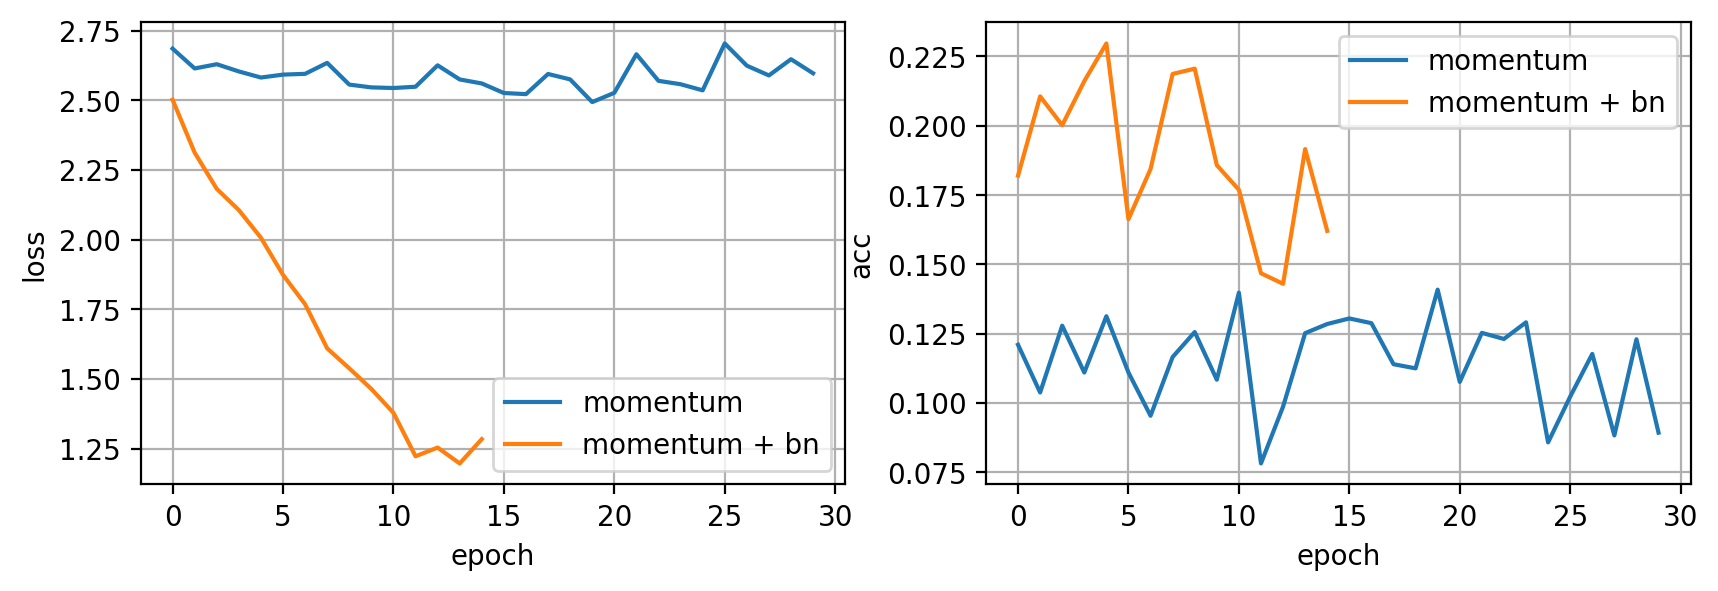

In [49]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(hist_momentum['loss'], label="momentum")
ax.plot(hist_bn['loss'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(hist_momentum['val_acc'], label="momentum")
ax.plot(hist_bn['val_acc'], label="momentum + bn")
ax.legend()
ax.grid(True)
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

# **MLP FINAL APLICANDO LOS MEJORES REGULADORES Y OPTIMIZADORES**

In [67]:
mean = (train_images / 255).mean(axis=(0, 1, 2))
std = (train_images / 255).std(axis=(0, 1, 2))

mean, std

(array([0.52439813, 0.50905477, 0.43398166]),
 array([0.27549254, 0.26727727, 0.28476294]))

In [68]:
train_images_norm = ((train_images / 255) - mean) / std
train_images_norm.mean(axis=(0, 1, 2)), train_images_norm.std(axis=(0, 1, 2))

(array([-3.44573364e-13, -1.09951066e-11, -5.65547064e-11]),
 array([1., 1., 1.]))

In [69]:
X_test_norm = np.array([(np.array(img)/255. - mean) / std for img, label in testset])

X_train_norm, X_val_norm, X_subset_norm = train_images_norm[:20000], train_images_norm[20000:], train_images_norm[:5000]

X_train_norm.shape, X_val_norm.shape, X_test_norm.shape, X_subset_norm.shape

((20000, 50, 50, 3), (10000, 50, 50, 3), (2407, 50, 50, 3), (5000, 50, 50, 3))

In [79]:
from albumentations import Compose, RandomCrop, Resize, HorizontalFlip, ToGray, RGBShift, OneOf

trans = Compose([
    RandomCrop(24,24),
    Resize(50, 50),
    HorizontalFlip(),
    OneOf([
        RGBShift(p=0.3)
    ])
])


class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, trans=None):
        self.X = X
        self.Y = Y
        self.trans = trans
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        img = self.X[ix]
        if self.trans:
            img = trans(image=img)["image"]
        img = torch.from_numpy(img / 255.).float().view(-1)
        label = torch.tensor(self.Y[ix]).long()
        return img, label


dataset = {
    'train': Dataset(X_train_norm, y_train),
    'val': Dataset(X_val_norm, y_val),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

len(dataset['train']), len(dataset['val'])

(20000, 10000)

In [71]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def build_model(D_in=50*50*3, H=100, D_out=15, p=0):
    return torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        #torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        #torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, H),
        #torch.nn.BatchNorm1d(H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p),
        torch.nn.Linear(H, D_out)
    )

In [56]:
def fit(model, dataloader, optimizer, scheduler=None, epochs=0, log_each=10, weight_decay=0, early_stopping=0):
    criterion = torch.nn.CrossEntropyLoss()
    l, acc, lr = [], [], []
    val_l, val_acc = [], []
    best_acc, step = 0, 0
    for e in range(1, epochs+1):
        _l, _acc = [], []
        for param_group in optimizer.param_groups:
            lr.append(param_group['lr'])
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        # guardar mejor modelo
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            torch.save(model.state_dict(), 'ckpt.pt')
            step = 0
            print(f"Mejor modelo guardado con acc {best_acc:.5f} en epoch {e}")
        step += 1
        if scheduler:
            scheduler.step()
        # parar
        if early_stopping and step > early_stopping:
            print(f"Entrenamiento detenido en epoch {e} por no mejorar en {early_stopping} epochs seguidas")
            break
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f} lr {lr[-1]:.5f}")
    # cargar mejor modelo
    model.load_state_dict(torch.load('ckpt.pt'))
    return {'epoch': list(range(1, len(l)+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc, 'lr': lr}

In [80]:
model = build_model(p=0.5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, step_size_up=5, step_size_down=25)
hist = fit(model, dataloader, optimizer, epochs=500, early_stopping=30)

Mejor modelo guardado con acc 0.06440 en epoch 1
Mejor modelo guardado con acc 0.07080 en epoch 2
Mejor modelo guardado con acc 0.07800 en epoch 9
Mejor modelo guardado con acc 0.09230 en epoch 10
Epoch 10/500 loss 2.70437 acc 0.07438 val_loss 2.70140 val_acc 0.09230 lr 0.01000
Mejor modelo guardado con acc 0.09470 en epoch 11
Mejor modelo guardado con acc 0.09480 en epoch 12
Mejor modelo guardado con acc 0.10430 en epoch 14
Mejor modelo guardado con acc 0.10580 en epoch 16
Mejor modelo guardado con acc 0.11060 en epoch 18
Mejor modelo guardado con acc 0.12280 en epoch 20
Epoch 20/500 loss 2.62768 acc 0.10658 val_loss 2.61017 val_acc 0.12280 lr 0.01000
Mejor modelo guardado con acc 0.12850 en epoch 23
Mejor modelo guardado con acc 0.12860 en epoch 27
Mejor modelo guardado con acc 0.13020 en epoch 28
Mejor modelo guardado con acc 0.13490 en epoch 29
Mejor modelo guardado con acc 0.13870 en epoch 30
Epoch 30/500 loss 2.58362 acc 0.12385 val_loss 2.57705 val_acc 0.13870 lr 0.01000
Mejor m

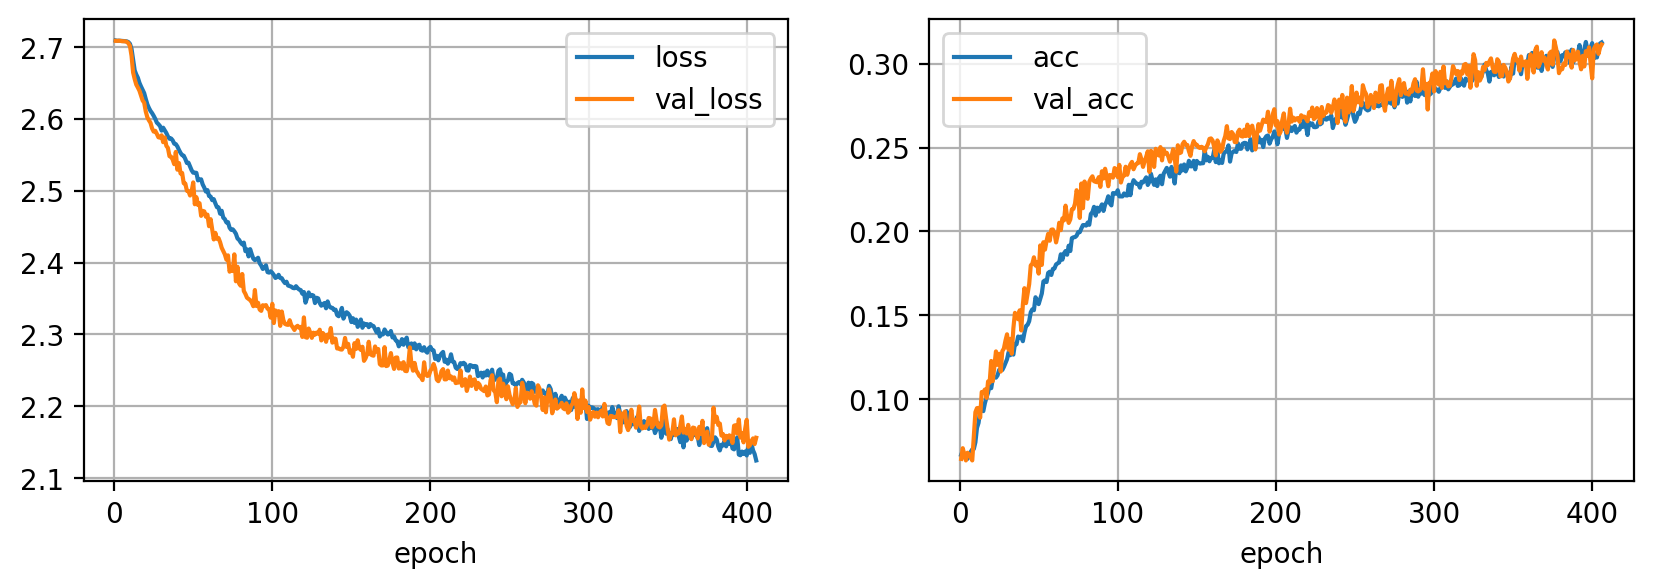

In [81]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()